# Gauss Model
- Gauss Model mit Rotation und Offset(Backgroundrauschen)
- erstellen und optimieren
- gute Funktion für erste Parameter entwickeln 
- Quelle: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as opt

In [12]:
#get Data
with open('.fit_area.npy', 'rb') as f:
        ar = np.load(f)

z_values_in = ar.flatten()
print(np.amax(z_values_in))
edge_x = ar.shape[1]
edge_y = ar.shape[0]
    #TO DO: double check if there is some better syntax
x_values = np.repeat(np.array([range(0,edge_x)]), edge_y, axis=0).flatten()
y_values = np.repeat(np.array([range(edge_y-1, -1, -1)]).reshape(edge_y,1), edge_x, axis=1).flatten()

# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax.set_title("data in")
# ax.scatter(x_values, y_values, z_values_in, c=z_values_in, cmap='viridis', linewidth=0.5)

# plt.show()

15373


In [13]:
#Basis Funktion
def twoD_Gaussian( x_y , amplitude, x_center, y_center, sigma_x, sigma_y, theta, offset):
    x, y = x_y
    xo = float(x_center)
    yo = float(y_center)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    result = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return result.ravel()


[ 1.52215376e+04  1.36233662e+02  7.49327246e+01  3.81108988e+01
  2.06084548e+01 -4.61367586e-02  1.50011644e+02]


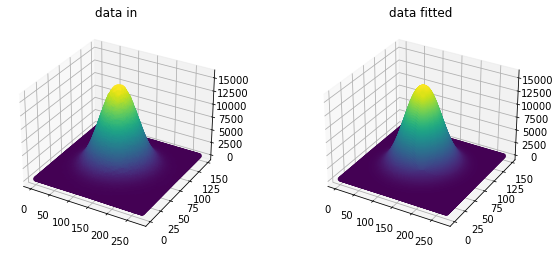

In [14]:
amplitude = 7810403
centerx = 136
centery = 74
sigmax = 38
sigmay = 21
min_val = 115

initial_guess = (amplitude,centerx,centery,sigmax,sigmay,0, min_val)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x_values, y_values), z_values_in, p0=initial_guess)

print(popt)

data_fitted = twoD_Gaussian((x_values, y_values), *popt)

fig = plt.figure(figsize=plt.figaspect(0.4))

#data
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title("data in")
ax.scatter(x_values, y_values, z_values_in, c=z_values_in, cmap='viridis', linewidth=0.5)

#data fittet
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("data fitted")
ax.scatter(x_values, y_values, data_fitted, c=data_fitted, cmap='viridis', linewidth=0.2)

plt.show()

## Überlegungen
- Aplitude entspricht ung max Wert? -> yes
- Rotation: Parameter Bounds sinnvoll?
- Rotation: an gedrehten Bsp testen
- Startwerte: anderes Modell (gleicher Code, oder Bibliothek importieren), oder aufsummieren -> timen
- Optimierung: mit verschiedenen Bildgrößen timen, func optimieren(check float oder int die ganze Zeit, Bastis Bibliothek)
- Subsampling
- Medianfilter, ganzes Bild oder nur fit_data?

### Subsampling
every other element in array --> Fit still working bei mls Bsp, bei  Bessy Bilder vermutlich nicht benutzen

In [15]:
#print(z_values_in.shape)
z_values_samp = z_values_in[0:(len(z_values_in)):3]
x_values_samp = x_values[0:(len(x_values)):3]
y_values_samp = y_values[0:(len(y_values)):3]

x_edge_samp = len(x_values_samp)-1
y_edge_samp = len(y_values_samp)-1
#print(z_values_samp.shape)
#print(x_values_samp.shape)
#print(y_values_samp.shape)

In [16]:
popt, pcov = opt.curve_fit(twoD_Gaussian, (x_values, y_values), z_values_in, p0=initial_guess)
print(popt)

popt_sam, pcov_sam = opt.curve_fit(twoD_Gaussian, (x_values_samp, y_values_samp), z_values_samp, p0=initial_guess)
print(popt_sam)

[ 1.52215376e+04  1.36233662e+02  7.49327246e+01  3.81108988e+01
  2.06084548e+01 -4.61367586e-02  1.50011644e+02]
[ 1.52111888e+04  1.36231422e+02  7.49288321e+01  3.81324732e+01
  2.06110481e+01 -4.59717062e-02  1.49593687e+02]


erst auf hinteren Kommastellen kleiner bis kein Unterschied --> gute Taktik

### Initial Values

In [17]:
def guess(x, y, z):
    """Estimate starting values from 2D peak data and create Parameters."""
    if x is None or y is None:
        return 1.0, 0.0, 0.0, 1.0, 1.0

    maxx, minx = np.amax(x), np.amin(x)
    maxy, miny = np.amax(y), np.amin(y)
    maxz, minz = np.amax(z), np.amin(z)

    centerx = x[np.argmax(z)]
    centery = y[np.argmax(z)]
    amplitude = (maxz - minz) #quasi height
    sigmax = (maxx-minx)/6.0
    sigmay = (maxy-miny)/6.0
    offset = minz

    return amplitude,centerx,centery,sigmax,sigmay, 0, offset

guess(x_values, y_values, z_values_in)

# amplitude = 7810403
# centerx = 136
# centery = 74
# sigmax = 38
# sigmay = 21
# min_val = 115

(15252, 133, 76, 46.0, 24.5, 0, 121)

In [18]:
from math import e, sqrt, pi

In [19]:
def guess_1D(im):    
    def gauss_func(x,m,s):
        return 1/(sqrt(2*pi)*s)*e**(-0.5*((x-m)/s)**2)
        
    sum_y = np.sum(im, axis=1)
    sum_x = np.sum(im, axis=0)

    edge_x = im.shape[1]
    edge_y = im.shape[0]

    x = np.array(range(0,edge_x))
    y = np.array(range(0,edge_y))
  
    #norm_x= (sum_x - min(sum_x)) / (max(sum_x) - min(sum_x))
    #norm_y= (sum_y - min(sum_y)) / (max(sum_y) - min(sum_y))

    norm_x=sum_x/(sum(sum_x))
    norm_y=sum_y/(sum(sum_y))

    # fig = plt.figure(figsize=plt.figaspect(0.4))

    # #data
    # ax = fig.add_subplot(1, 2, 1)
    # ax.set_title("x")
    # ax.plot(x, norm_x)

    # #data fittet
    # ax = fig.add_subplot(1, 2, 2)
    # ax.set_title("y")
    # ax.plot(y, norm_y)

    #x-werte
    popt_x, pcov_x = opt.curve_fit(gauss_func, x, norm_x)
    #print('[cent_x, sig_x]',popt_x)

    #y-werte
    popt_y, pcov_y = opt.curve_fit(gauss_func, y,norm_y)
    #print('[cent_y, sig_y]',popt_y)

    return (np.amax(im),popt_x[0], popt_y[0], popt_x[1], popt_y[1],0,np.amin(im))
    
guess_1d = guess_1D(ar)
guess_1d
###############To DO: check each of the values/arays
#(133, 76, 46.0, 24.5)
#centerx,centery,sigmax,sigmay

#136  74  38  20

(15373,
 136.2775092722025,
 72.08015863496064,
 40.19710941254685,
 21.740506220034725,
 0,
 121)

In [20]:
#alle printanweisungen auskommentiert
%timeit g = guess(x_values,y_values,z_values_in)
%timeit g1= guess_1D(ar)
#print(g)
#print(g1)

262 µs ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.97 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Rotation
- Ellipse auf dem x-y Feld, also wenn man von oben drauf guckt, kann nie mehr als 90 Grad gekippt sein, dann stimmt der x/y Achsenwert wieder. 
- außerdem ist die Ellipse ja Tendez spiegelverkeht und kann dann auch nicht mehr als das gedreht werden oooooooder nicht?
- radiant für 90° -> pi/2 = 1.5707963267949 
- Paramter Bound 0 bis pi/2
- weiterer Gedanke: Amplitude nie größer als 14 Bit (16.383-1)


In [21]:
with open('.fit_area_rot.npy', 'rb') as f:
        ar_rot = np.load(f)

z_values_rot = ar_rot.flatten()
edge_x_rot = ar_rot.shape[1]
edge_y_rot = ar_rot.shape[0]
    #TO DO: double check if there is some better syntax
x_values_rot = np.repeat(np.array([range(0,edge_x_rot)]), edge_y_rot, axis=0).flatten()
y_values_rot = np.repeat(np.array([range(edge_y_rot-1, -1, -1)]).reshape(edge_y_rot,1), edge_x_rot, axis=1).flatten()

initial_guess_rot = guess(x_values_rot, y_values_rot, z_values_rot)

In [22]:
popt_rot, pcov_rot = opt.curve_fit(twoD_Gaussian, (x_values_rot, y_values_rot), z_values_rot, p0=initial_guess_rot)
print(popt_rot)

[1.31783768e+04 2.73193354e+02 2.14165412e+02 7.96854001e+01
 6.28353154e+01 2.72593032e-01 1.21805600e+02]


0,2 ist auf jeden Fall schonmal schräger als 0, aber sollten man mal ein Bild selber drehen und testen

[5.78960291e+01 7.93406701e+01 7.44769719e+01 3.43652923e+01
 1.80920482e+01 4.98922870e-01 1.20166430e-18]


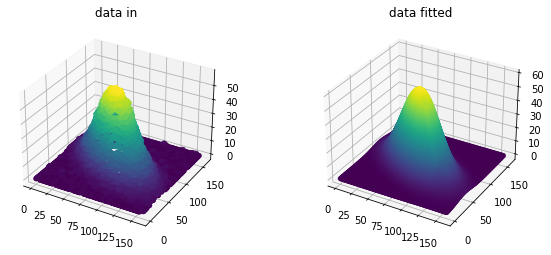

In [23]:
with open('rotation3.npy', 'rb') as f:
        ar_rot = np.load(f)

z_values_rot = ar_rot.flatten()
edge_x_rot = ar_rot.shape[1]
edge_y_rot = ar_rot.shape[0]
    #TO DO: double check if there is some better syntax
x_values_rot = np.repeat(np.array([range(0,edge_x_rot)]), edge_y_rot, axis=0).flatten()
y_values_rot = np.repeat(np.array([range(edge_y_rot-1, -1, -1)]).reshape(edge_y_rot,1), edge_x_rot, axis=1).flatten()

initial_guess_rot = guess(x_values_rot, y_values_rot, z_values_rot)
bounds_rot = (0, [16382, edge_x_rot, edge_y_rot, edge_x_rot, edge_y_rot, pi/2, 16382])

popt_rot, pcov_rot = opt.curve_fit(twoD_Gaussian, (x_values_rot, y_values_rot), z_values_rot, p0=initial_guess_rot, bounds=bounds_rot)
print(popt_rot)

data_fitted_rot = twoD_Gaussian((x_values_rot, y_values_rot), *popt_rot)

fig = plt.figure(figsize=plt.figaspect(0.4))

#data
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title("data in")
ax.scatter(x_values_rot, y_values_rot, z_values_rot, c=z_values_rot, cmap='viridis', linewidth=0.5)

#data fittet
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("data fitted")
ax.scatter(x_values_rot, y_values_rot, data_fitted_rot, c=data_fitted_rot, cmap='viridis', linewidth=0.2)

plt.show()


der Winkel sollte einen bound haben,  kommen vielfache des Winkels raus und kein eindeutiges Ergebnis

### Bounds

In [24]:
#Überlegung:
#initial_guess = (amplitude,centerx,centery,sigmax,sigmay,0, min_val)
bounds_inf = (0, [np.inf, np.inf, np.inf, np.inf, np.inf, pi/2, np.inf])

In [25]:
#for rotierte Daten
bounds_rot = (0, [16382, edge_x_rot, edge_y_rot, edge_x_rot, edge_y_rot, pi/2, 16382])
%timeit opt.curve_fit(twoD_Gaussian, (x_values_rot, y_values_rot), z_values_rot, p0=initial_guess_rot, bounds=bounds_rot)
%timeit opt.curve_fit(twoD_Gaussian, (x_values_rot, y_values_rot), z_values_rot, p0=initial_guess_rot, bounds=bounds_inf)
%timeit opt.curve_fit(twoD_Gaussian, (x_values_rot, y_values_rot), z_values_rot, p0=initial_guess_rot)

132 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
126 ms ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
73.1 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
#for sampled data
bounds_samp = (0, [16382, x_edge_samp, y_edge_samp, x_edge_samp, y_edge_samp, pi/2, 16382])
initial_guess_sam =guess(x_values_samp, y_values_samp, z_values_samp)
%timeit opt.curve_fit(twoD_Gaussian, (x_values_samp, y_values_samp), z_values_samp, p0=initial_guess_sam, bounds=bounds_samp)
%timeit opt.curve_fit(twoD_Gaussian, (x_values_samp, y_values_samp), z_values_samp, p0=initial_guess_sam, bounds=bounds_inf)
%timeit opt.curve_fit(twoD_Gaussian, (x_values_samp, y_values_samp), z_values_samp, p0=initial_guess_sam)


49.4 ms ± 8.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.2 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.8 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
#for normale Daten
bounds = (0, [16382, edge_x, edge_y, edge_x, edge_y, pi/2, 16382])
initial_guess = guess(x_values, y_values, z_values_in)
%timeit opt.curve_fit(twoD_Gaussian, (x_values, y_values), z_values_in, p0=initial_guess, bounds=bounds)
%timeit opt.curve_fit(twoD_Gaussian, (x_values, y_values), z_values_in, p0=initial_guess, bounds=bounds_inf)
%timeit opt.curve_fit(twoD_Gaussian, (x_values, y_values), z_values_in, p0=initial_guess)

144 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
131 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
77.5 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


mit boundaries, jednfalls länger
vlt später im Programm, mit boundaries laufen lassen und dann überprüfen und wenn nicht richtig mit Boundaries laufen lassen 

### Normalizierung
beime 1d Fit darauf gestoßen das Werte vlt normalisiert werden könnten, damit besseres Ergebnis 
Die Frage ist wie genau und warum

### x, y Werte
besser vlt ganz an Anfang ein großes x Feld und y Feld zu erstellen und das dann nur noch zu scheniden ist

### besserer Guess

In [59]:
def guess_opt(x, y, z, im):
    """Estimate starting values from 2D peak data and create Parameters."""
    if x is None or y is None:
        return 1.0, 0.0, 0.0, 1.0, 1.0

    maxx, minx = np.amax(x), np.amin(x)
    maxy, miny = np.amax(y), np.amin(y)
    maxz, minz = np.amax(z), np.amin(z)

    centerx = x[np.argmax(z)]
    centery = y[np.argmax(z)]
    amplitude = (maxz - minz)  
    offset = minz

    #decide fo a point for calculating heigt 
    # median = np.median(z)
    # index = np.where(z == median)[0]
    # x_coordinate = x[index]
    # y_coordinate = y[index]

    print(np.amax(im))
    print(im.shape)
    sum_y = im.mean(axis=1)
    print(np.max(sum_y))
    sum_x = np.mean(im, axis=0)

    plt.plot(np.array(range(0, im.shape[0])), sum_y)  # <- or here
    plt.show()

    sigmax = np.std(sum_y)
    sigmay = np.std(sum_x)

    initial_params = amplitude, centerx, centery, sigmax, sigmay, 0, offset
    print(initial_params)
    
    #to make sure rotation is aproximatly right
    bounds = bounds = ([0,0,0,0,0, -pi/2, 0], [16382, edge_x, edge_y, edge_x, edge_y, pi/2, 16382])
    popt, pcov = opt.curve_fit(self.twoD_Gaussian, (x, y),
                                z,  p0=self.initial_params, bounds=bounds)
    result = popt

    return amplitude, centerx, centery, sigmax, sigmay, 0, offset

[1.31783768e+04 2.73193354e+02 2.14165412e+02 7.96854001e+01
 6.28353154e+01 2.72593032e-01 1.21805600e+02]

15373
(148, 277)
5370.938628158845


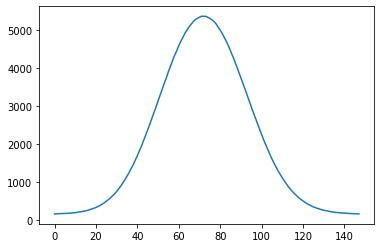

(15252, 133, 76, 1856.190549460204, 1872.9914349042367, 0, 121)


NameError: name 'self' is not defined

In [60]:
with open('.fit_area.npy', 'rb') as f:
        ar = np.load(f)

print(guess_opt(x_values, y_values, z_values_in, ar))